In [1]:
import pandas as pd
import numpy as np
import datetime 
import re
from urlextract import URLExtract
import spacy
import time
import pickle
import matplotlib.pyplot as plt

In [2]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
extractor = URLExtract()
# remove all urls from posts
def replace_urls(x):
    urls = extractor.find_urls(x)
    if urls:
        x_new = replace_urls(x.replace(urls[0],''))
        return x_new
    else:
        return x

In [4]:
# df_full = pd.read_csv('data/anxiety_full.csv', low_memory=False)
depression = pd.read_csv('data/depression_topics.csv', low_memory=False, lineterminator='\n')
depression.drop(columns=['Unnamed: 0'], inplace=True)

In [6]:
anxiety = pd.read_csv('data/anxiety_topics.csv', low_memory=False, lineterminator='\n')
anxiety.drop(columns=['Unnamed: 0'], inplace=True)

In [7]:
depression['date'] = pd.to_datetime(depression.date)
anxiety['date'] = pd.to_datetime(anxiety.date)

In [8]:
# anxiety.max_topic.value_counts()

In [9]:
anxiety.dropna(subset=['selftext'], inplace=True)
depression.dropna(subset=['selftext'], inplace=True)

In [10]:

# testing = anxiety
# testing['social_label'] = anxiety['friends/hang/groups'] + anxiety['social/media/situations']
# anxiety_social = testing.sort_values(by=['social_label'], ascending=False).head(18082)

In [11]:
import gensim
import multiprocessing
from tqdm import tqdm
from sklearn import utils
from gensim.models.callbacks import CallbackAny2Vec

In [32]:


class LossLogger(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 0
        self.loss_to_be_subed = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subed
        self.loss_to_be_subed = loss
        print('Loss after epoch {}: {}'.format(self.epoch, loss_now))
        self.epoch += 1

loss_logger = LossLogger()
cores = multiprocessing.cpu_count()

documents = anxiety.text_title
tokenized_docs = [gensim.utils.simple_preprocess(d) for d in documents]
model = gensim.models.Word2Vec(tokenized_docs,
                               size=300,
                               window=5,
                               min_count=10,
                               sg=1,
                               callbacks=[loss_logger],
                               compute_loss=True,
                               iter=45,
                               workers=cores)

Loss after epoch 0: 12973423.0
Loss after epoch 1: 10665455.0
Loss after epoch 2: 10240402.0
Loss after epoch 3: 6421108.0
Loss after epoch 4: 6403156.0
Loss after epoch 5: 6357872.0
Loss after epoch 6: 6352768.0
Loss after epoch 7: 6334340.0
Loss after epoch 8: 1473380.0
Loss after epoch 9: 141008.0
Loss after epoch 10: 143192.0
Loss after epoch 11: 141576.0
Loss after epoch 12: 144488.0
Loss after epoch 13: 144736.0
Loss after epoch 14: 145144.0
Loss after epoch 15: 142248.0
Loss after epoch 16: 145368.0
Loss after epoch 17: 144000.0
Loss after epoch 18: 140728.0
Loss after epoch 19: 140168.0
Loss after epoch 20: 138696.0
Loss after epoch 21: 137944.0
Loss after epoch 22: 135008.0
Loss after epoch 23: 137760.0
Loss after epoch 24: 135472.0
Loss after epoch 25: 133704.0
Loss after epoch 26: 133528.0
Loss after epoch 27: 132104.0
Loss after epoch 28: 128648.0
Loss after epoch 29: 129840.0
Loss after epoch 30: 128160.0
Loss after epoch 31: 127712.0
Loss after epoch 32: 128112.0
Loss aft

In [40]:
model.save("models/anxiety2vec.model")

In [36]:
model.wv.most_similar(['scared'], topn=10)

[('afraid', 0.8332506418228149),
 ('terrified', 0.780756950378418),
 ('worried', 0.6253881454467773),
 ('nervous', 0.4967040717601776),
 ('fearful', 0.4952450692653656),
 ('petrified', 0.49504226446151733),
 ('paranoid', 0.47631195187568665),
 ('shitless', 0.46545976400375366),
 ('scares', 0.4584802985191345),
 ('frightened', 0.4548741579055786)]

In [798]:
anxiety[anxiety.selftext.str.contains(' reddit ')].values[2]

array([1449943401, 'Anxiety', 'determinism101', 'self.Anxiety',
       'https://www.reddit.com/r/Anxiety/comments/3wjfio/why_has_the_idea_of_determinism_sent_me_crazy/',
       2, 3, 3.0, 0.0, 'Why has the idea of determinism sent me crazy?',
       "For some reason after reading about determinism I feel like I have gone absolutely crazy. The idea that are lives are unfolding and we don't have real control over it. Now when I look at people I feel like I'm looking at computers just doing what they do and feel like I have lost all connection with people. This thought has given me horrendous anxiety, I feel like I don't even know where I am any more. My question reddit is this just anxiety making me feel like the thought is crazy or is it the thought? Surely finding out something can't send you crazy... ",
       False, '3wjfio', nan, 0, nan, False, 1454923681, False, 'self',
       't5_2qmij', False, 'venting', nan, False, True, nan,
       '/r/Anxiety/comments/3wjfio/why_has_the_idea_o

In [38]:
model.wv.most_similar(positive=['social', 'media', 'account'], topn=30)

[('facebook', 0.6033738851547241),
 ('accounts', 0.5652605295181274),
 ('instagram', 0.5491209626197815),
 ('twitter', 0.540290355682373),
 ('medias', 0.5301116108894348),
 ('myspace', 0.5134504437446594),
 ('reddit', 0.5121648907661438),
 ('profiles', 0.47724026441574097),
 ('deleted', 0.4764728844165802),
 ('fb', 0.47510743141174316),
 ('throwaway', 0.4517183005809784),
 ('deactivating', 0.45092451572418213),
 ('unfollowed', 0.4495944082736969),
 ('snapchat', 0.44644638895988464),
 ('messenger', 0.4358212351799011),
 ('tumblr', 0.43365478515625),
 ('notifications', 0.4313971996307373),
 ('deleting', 0.42993658781051636),
 ('follower', 0.4262659549713135),
 ('networks', 0.4211564064025879),
 ('delete', 0.4209303557872772),
 ('profile', 0.41852259635925293),
 ('vanity', 0.41416120529174805),
 ('internet', 0.4139171242713928),
 ('unfollow', 0.4134800434112549),
 ('reactivated', 0.4108877182006836),
 ('gatherings', 0.40727341175079346),
 ('tinder', 0.40713581442832947),
 ('platforms', 0.

In [39]:
model.wv.most_similar(positive=['media', 'anxiety'], negative=['social'], topn=30)

[('facebook', 0.39895033836364746),
 ('accounts', 0.379080593585968),
 ('anxieties', 0.3737826645374298),
 ('instagram', 0.37294507026672363),
 ('deleted', 0.37185147404670715),
 ('twitter', 0.3604085445404053),
 ('worldnews', 0.33075159788131714),
 ('youtube', 0.31879836320877075),
 ('apps', 0.31624263525009155),
 ('sites', 0.3092844486236572),
 ('eli', 0.30707189440727234),
 ('deactivating', 0.30559730529785156),
 ('news', 0.3049636483192444),
 ('reddit', 0.3044201135635376),
 ('paranoia', 0.3014766275882721),
 ('internet', 0.2979758381843567),
 ('panic', 0.2962847054004669),
 ('anxiey', 0.2954588532447815),
 ('ebook', 0.2949087619781494),
 ('anxiousness', 0.29231661558151245),
 ('cnn', 0.29157429933547974),
 ('anixety', 0.28937584161758423),
 ('scrolling', 0.28798019886016846),
 ('browsing', 0.2842468023300171),
 ('snapchat', 0.28392496705055237),
 ('site', 0.2838783264160156),
 ('gad', 0.2837258279323578),
 ('posts', 0.2835172116756439),
 ('mongering', 0.2826034128665924),
 ('tweet

In [ ]:
# model2.wv.most_similar(['motivation'], topn=30)

In [ ]:
# model.save("models/anxiety2vec_full.model")

In [543]:
model1 = gensim.models.Word2Vec.load("models/anxiety2vec_full.model")
model2 = gensim.models.Word2Vec.load("models/depression2vec_full.model")

In [163]:
model2.wv.most_similar(['motivation'], topn=30)

[('energy', 0.6299775838851929),
 ('willpower', 0.6144546270370483),
 ('ambition', 0.5886609554290771),
 ('motvation', 0.5381804704666138),
 ('modivation', 0.5302222967147827),
 ('motiviation', 0.5192931294441223),
 ('motovation', 0.5171259641647339),
 ('desire', 0.5122600197792053),
 ('enthusiasm', 0.4983682632446289),
 ('motivated', 0.494276225566864),
 ('inspiration', 0.4916467070579529),
 ('unmotivated', 0.4851604998111725),
 ('passion', 0.48500457406044006),
 ('strengh', 0.4655093550682068),
 ('appetite', 0.46231281757354736),
 ('strength', 0.4595683515071869),
 ('zest', 0.45696038007736206),
 ('motivate', 0.4507544934749603),
 ('determination', 0.4479437470436096),
 ('confidence', 0.44607073068618774),
 ('preparedness', 0.4441033601760864),
 ('gumption', 0.44054946303367615),
 ('acomplishment', 0.43923187255859375),
 ('strenght', 0.43693986535072327),
 ('willingness', 0.4365207552909851),
 ('lustre', 0.4341988265514374),
 ('concentration', 0.4321267008781433),
 ('apetite', 0.4266

In [214]:
model1.wv.most_similar(positive=['psychiatrist'], negative=['prescribed'], topn=40)

[('therapist', 0.4170568585395813),
 ('psychologist', 0.36235499382019043),
 ('counselor', 0.3517606854438782),
 ('doctor', 0.29781460762023926),
 ('physiatrist', 0.2623823881149292),
 ('therapists', 0.25169387459754944),
 ('psychoanalyst', 0.2405727207660675),
 ('gp', 0.23925045132637024),
 ('pdoc', 0.2323845624923706),
 ('counseling', 0.23211266100406647),
 ('psych', 0.22802326083183289),
 ('clinician', 0.22732265293598175),
 ('psychotherapist', 0.2258133590221405),
 ('pcp', 0.2244172990322113),
 ('md', 0.22144736349582672),
 ('doctors', 0.22106030583381653),
 ('councelor', 0.21885794401168823),
 ('sessions', 0.21844717860221863),
 ('hypnotherapist', 0.21836623549461365),
 ('occupational', 0.2171756476163864),
 ('discuss', 0.21669895946979523),
 ('psychiatrists', 0.21437397599220276),
 ('counsellor', 0.21428753435611725),
 ('doc', 0.21034356951713562),
 ('counselors', 0.2061026245355606),
 ('pcm', 0.20398318767547607),
 ('physiologist', 0.20296108722686768),
 ('appointment', 0.202683

In [527]:
anxiety.selftext.isna().sum()

0

In [672]:
depression[depression.selftext.str.contains('ssris') & depression.selftext.str.contains('erectile')]

,created_utc,subreddit,author,domain,url,num_comments,score,ups,downs,title,...,tired/sick,friends/lonely,school,depressed/suicidal/reason,sleep,job,friend/best/girl,sad,kill/suicide,max_topic


In [674]:
model2.wv.most_similar(positive=['depressant'], negative=['stimulant'],topn=10)

[('anti', 0.3983129858970642),
 ('depressants', 0.3530580401420593),
 ('depressents', 0.19163519144058228),
 ('antidepressants', 0.15999141335487366),
 ('abortion', 0.15711236000061035),
 ('amazing', 0.1542251706123352),
 ('psychotics', 0.14911118149757385),
 ('anywho', 0.14821702241897583),
 ('eyeing', 0.14802893996238708),
 ('fireworks', 0.14783577620983124)]

In [670]:
model2.wv.most_similar(positive=['insomnia', 'ssris'], negative=['adderall'],topn=10)

[('effects', 0.40463900566101074),
 ('anorgasmia', 0.4025641083717346),
 ('snris', 0.40243127942085266),
 ('antipsychotics', 0.39718884229660034),
 ('erectile', 0.39101123809814453),
 ('lightheadedness', 0.38974010944366455),
 ('bloating', 0.3887931704521179),
 ('tardive', 0.3864535689353943),
 ('premenstrual', 0.3841016888618469),
 ('dizziness', 0.3823544383049011)]

In [669]:
model2.wv.most_similar(positive=['insomnia', 'ssris'], negative=['adderall'],topn=40)

[('effects', 0.40463900566101074),
 ('anorgasmia', 0.4025641083717346),
 ('snris', 0.40243127942085266),
 ('antipsychotics', 0.39718884229660034),
 ('erectile', 0.39101123809814453),
 ('lightheadedness', 0.38974010944366455),
 ('bloating', 0.3887931704521179),
 ('tardive', 0.3864535689353943),
 ('premenstrual', 0.3841016888618469),
 ('dizziness', 0.3823544383049011),
 ('bruxism', 0.38129884004592896),
 ('discontinuation', 0.37654173374176025),
 ('tremors', 0.3745548725128174),
 ('tricyclics', 0.37176477909088135),
 ('shakiness', 0.37167757749557495),
 ('headaches', 0.37068483233451843),
 ('somnolence', 0.3702065050601959),
 ('cystitis', 0.36915984749794006),
 ('depresseion', 0.3684377670288086),
 ('antidepressants', 0.36777713894844055),
 ('ssri', 0.36683154106140137),
 ('insomina', 0.36555981636047363),
 ('thyroxine', 0.3652310371398926),
 ('sleepiness', 0.36522993445396423),
 ('dyskinesia', 0.3647785484790802),
 ('gynophobia', 0.3647738993167877),
 ('spasms', 0.3638470768928528),
 ('

In [658]:
model2.wv.most_similar(positive=['appetite', 'ssris'], negative=['adderall'],topn=10)

[('libido', 0.4457560181617737),
 ('apatite', 0.42408931255340576),
 ('apetite', 0.42253684997558594),
 ('bloating', 0.39850419759750366),
 ('dryness', 0.38771119713783264),
 ('anorgasmia', 0.3690098822116852),
 ('disfunction', 0.363569974899292),
 ('erectile', 0.35221922397613525),
 ('backaches', 0.34334316849708557),
 ('agitation', 0.34310317039489746)]

In [446]:
# diff = model1.wv['libido'] + model1.wv['antidepressant']
# model2.wv.most_similar(['girl'],topn=100)

In [447]:
diff = model1.wv['adderall'] - model1.wv['anxiety'] + model1.wv['zoloft']
model1.wv.similar_by_vector(diff,topn=40)
# model2.wv.most_similar(positive=['appetite', 'zoloft'], negative=['adderall'], topn=40)

[('adderall', 0.862360954284668),
 ('zoloft', 0.768336296081543),
 ('lexapro', 0.6772686839103699),
 ('prozac', 0.6394789218902588),
 ('wellbutrin', 0.6265290379524231),
 ('mg', 0.6234655380249023),
 ('effexor', 0.6217649579048157),
 ('buspar', 0.6215677261352539),
 ('paxil', 0.617989718914032),
 ('celexa', 0.5816007852554321),
 ('xr', 0.5798400044441223),
 ('sertraline', 0.5756921768188477),
 ('xanax', 0.565936803817749),
 ('citalopram', 0.5538364052772522),
 ('seroquel', 0.5419552326202393),
 ('klonopin', 0.5417829751968384),
 ('cymbalta', 0.5406736135482788),
 ('vyvanse', 0.5397576093673706),
 ('concerta', 0.5226377844810486),
 ('medication', 0.522387683391571),
 ('fluoxetine', 0.5221703052520752),
 ('lustral', 0.5155850052833557),
 ('ritalin', 0.514403760433197),
 ('mirtazapine', 0.5125428438186646),
 ('lamotragine', 0.5123746395111084),
 ('escitalopram', 0.5119099617004395),
 ('buspirone', 0.5094854235649109),
 ('elicea', 0.5057764053344727),
 ('zolaft', 0.5055547952651978),
 ('ox

In [636]:
# sanity check
print(model2.wv.most_similar(positive=['girl', 'man'], negative=['boy'], topn=1))
print(model2.wv.most_similar(positive=['good', 'sad'], negative=['bad'], topn=1))
# print(model2.wv.most_similar(positive=['america', 'japan'], negative=['comics'], topn=10))
print(model1.wv.most_similar(positive=['anime', 'usa'], negative=['japan'], topn=10))
print()
print(model1.wv.most_similar(positive=['manga', 'america'], negative=['japan'], topn=10))
print(model2.wv.most_similar(positive=['appetite', 'ssris'], negative=['adderall'],topn=1))

[('woman', 0.622362494468689)]
[('happy', 0.39836597442626953)]
[('horseman', 0.3003823161125183), ('dexter', 0.28333941102027893), ('animated', 0.2801300287246704), ('bojack', 0.27456095814704895), ('gintama', 0.272478848695755), ('jones', 0.2678701877593994), ('yt', 0.254575252532959), ('merch', 0.25352585315704346), ('scrolls', 0.24711772799491882), ('wonderland', 0.2438838928937912)]

[('markiplier', 0.37149134278297424), ('goldberg', 0.34644973278045654), ('superheroes', 0.3300613760948181), ('fandom', 0.32999029755592346), ('morty', 0.32127389311790466), ('sociopaths', 0.32021793723106384), ('kart', 0.31943899393081665), ('gimmicky', 0.31575334072113037), ('pl', 0.3146938383579254), ('discourse', 0.31244224309921265)]
[('libido', 0.4457560181617737)]


In [897]:
print(model1.wv.most_similar(positive=['man', 'gives'], negative=['woman'], topn=10))


[('giving', 0.43007081747055054), ('gave', 0.4018990099430084), ('give', 0.37458306550979614), ('makes', 0.37081873416900635), ('causes', 0.35473302006721497), ('brings', 0.3232537508010864), ('creates', 0.29973191022872925), ('sends', 0.2936379611492157), ('feeds', 0.2917942702770233), ('saves', 0.2890743613243103)]


In [922]:
print(model2.wv.most_similar(positive=['woman', 'gives'], negative=['man'], topn=10))


[('gave', 0.41349464654922485), ('provides', 0.36381933093070984), ('give', 0.3576871156692505), ('giving', 0.31530657410621643), ('makes', 0.3097561001777649), ('brings', 0.3073192834854126), ('appreciable', 0.3028218150138855), ('likes', 0.2827165722846985), ('cares', 0.2826090455055237), ('comforts', 0.2820512354373932)]


In [972]:
wt = model1.wv.most_similar(positive=['man', 'asked'], negative=['woman'], topn=9)
mt = model2.wv.most_similar(positive=['woman', 'asked'], negative=['woman'], topn=10)

wt_words = [w[0] for w in wt]
a = ' '.join(wt_words)
a


'ask asking told asks said pleasured smirked tell offered'

In [939]:
print(model2.wv.most_similar(positive=['man', 'talks'], negative=['woman'], topn=10))


[('brags', 0.3985859751701355), ('talk', 0.38265013694763184), ('speaks', 0.361060231924057), ('cares', 0.3573610186576843), ('punchlines', 0.3244349956512451), ('talked', 0.32361406087875366), ('ignores', 0.321233332157135), ('ronnie', 0.32004183530807495), ('pouts', 0.3197791874408722), ('mumbles', 0.3186509609222412)]


In [931]:
print(model2.wv.most_similar(positive=['man', 'asked'], negative=['woman'], topn=12))


[('ask', 0.49817124009132385), ('asks', 0.47522276639938354), ('asking', 0.4307596683502197), ('told', 0.3933787941932678), ('said', 0.36379486322402954), ('whyd', 0.3524198830127716), ('siad', 0.34495481848716736), ('askes', 0.32784074544906616), ('sahil', 0.3272550106048584), ('fudged', 0.3271654546260834), ('summerfield', 0.32672321796417236), ('stapler', 0.31757211685180664)]


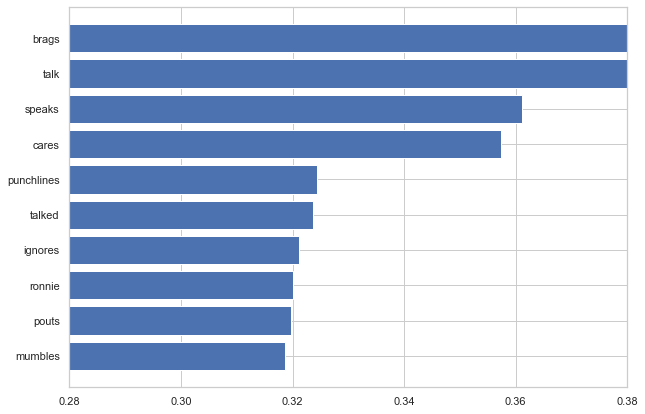

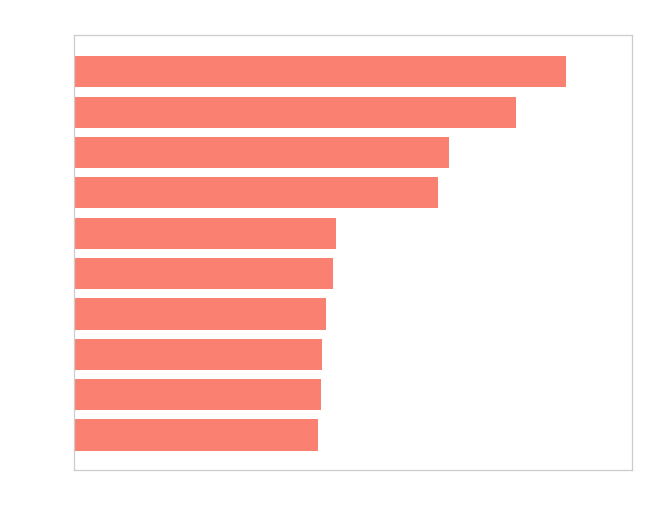

In [947]:
a = model2.wv.most_similar(positive=['girl', 'man'], negative=['boy'], topn=1)
b = model2.wv.most_similar(positive=['good', 'sad'], negative=['bad'], topn=1)
# print(model2.wv.most_similar(positive=['america', 'japan'], negative=['comics'], topn=10))
c = model1.wv.most_similar(positive=['anime', 'usa'], negative=['japan'], topn=10)
print()
d = model1.wv.most_similar(positive=['manga', 'america'], negative=['japan'], topn=13)
e = model2.wv.most_similar(positive=['appetite', 'ssris'], negative=['adderall'],topn=1)


wt = model2.wv.most_similar(positive=['woman', 'talks'], negative=['man'], topn=10)
mt = model2.wv.most_similar(positive=['man', 'talks'], negative=['woman'], topn=10)

funny_list = [[item[0], round(item[1], 4)] for item in mt]
funny_list2 = funny_list[::-1]
# arr = np.array(funny_list2)
x = [item[0] for item in funny_list2]
y = [item[1] for item in funny_list2]

# x = arr[:,0]
# y= arr[:,1]
plt.figure(figsize=[10, 7])
plt.xlim([.28, .38])
plt.barh(x, y)


fig, ax = plt.subplots(figsize=[10, 8])
plt.title('Man - Woman + Talks\n', color='white', fontsize=13)
ax.barh(x, y, color = 'salmon')
plt.xlabel('Cosine Similarity', fontsize=12, color='white', fontname='Osaka')
plt.grid(False)
plt.xlim([.24, .42])
ax.axes.tick_params(axis="y", colors='white', labelsize=12)
ax.axes.tick_params(axis="x", colors="white", labelsize=12)
plt.savefig('MARKIPLIER.png', transparent=True, dpi=300)

In [ ]:
# f = ('markiplier', 0.37149134278297424)
#  ('goldberg', 0.34644973278045654),
#  ('superheroes', 0.3300613760948181),
#  ('fandom', 0.32999029755592346),
#  ('morty', 0.32127389311790466),
#  ('sociopaths', 0.32021793723106384),
#  ('kart', 0.31943899393081665),
#  ('gimmicky', 0.31575334072113037),
#  ('pl', 0.3146938383579254),
#  ('discourse', 0.31244224309921265),
#  ('cowboys', 0.3116625249385834),
#  ('merch', 0.31049060821533203),
#  ('barbie', 0.31040382385253906)

In [ ]:
appetite

In [498]:
model2.wv.most_similar(['energy'], topn=20)

[('motivation', 0.6299775838851929),
 ('willpower', 0.5869029760360718),
 ('strength', 0.5702896118164062),
 ('strenght', 0.4565954804420471),
 ('stamina', 0.4520929455757141),
 ('brainpower', 0.4397153854370117),
 ('enthusiasm', 0.43684160709381104),
 ('zapped', 0.43670618534088135),
 ('alertness', 0.4328494966030121),
 ('engery', 0.4322839379310608),
 ('expending', 0.42276492714881897),
 ('expend', 0.4140675663948059),
 ('motvation', 0.4118460416793823),
 ('fortitude', 0.40987902879714966),
 ('strengh', 0.40971967577934265),
 ('motiviation', 0.4093519449234009),
 ('vigor', 0.4091150760650635),
 ('therof', 0.4033835530281067),
 ('ambition', 0.403373122215271),
 ('modivation', 0.39942219853401184)]

In [513]:
model2.wv.most_similar(positive=['appetite', 'ssris'], negative=['stimulants'], topn=20)

[('libido', 0.44634950160980225),
 ('apetite', 0.43654346466064453),
 ('apatite', 0.4281459450721741),
 ('bloating', 0.3791866600513458),
 ('wb', 0.3717849850654602),
 ('erectile', 0.37156715989112854),
 ('digestion', 0.36950254440307617),
 ('ssri', 0.3597300946712494),
 ('anorgasmia', 0.358379065990448),
 ('dryness', 0.35025569796562195),
 ('celexa', 0.3492080569267273),
 ('lightheadedness', 0.346529483795166),
 ('zoloft', 0.3455219864845276),
 ('anafranil', 0.3453870415687561),
 ('nausea', 0.3445394039154053),
 ('ejaculation', 0.3420006036758423),
 ('disfunction', 0.33480381965637207),
 ('insomnia', 0.33475327491760254),
 ('prozac', 0.33397024869918823),
 ('headaches', 0.33392783999443054)]

In [488]:
# model.most_similar(positive=['paris', 'australia'], negative=['france'], topn=10)
model2.wv.most_similar(positive=['appetite', 'ssris'], negative=['stimulants'], topn=20)

[('libido', 0.44634950160980225),
 ('apetite', 0.43654346466064453),
 ('apatite', 0.4281459450721741),
 ('bloating', 0.3791866600513458),
 ('wb', 0.3717849850654602),
 ('erectile', 0.37156715989112854),
 ('digestion', 0.36950254440307617),
 ('ssri', 0.3597300946712494),
 ('anorgasmia', 0.358379065990448),
 ('dryness', 0.35025569796562195),
 ('celexa', 0.3492080569267273),
 ('lightheadedness', 0.346529483795166),
 ('zoloft', 0.3455219864845276),
 ('anafranil', 0.3453870415687561),
 ('nausea', 0.3445394039154053),
 ('ejaculation', 0.3420006036758423),
 ('disfunction', 0.33480381965637207),
 ('insomnia', 0.33475327491760254),
 ('prozac', 0.33397024869918823),
 ('headaches', 0.33392783999443054)]

In [449]:
model2.wv.most_similar(['insomnia'], topn=30)

[('hypersomnia', 0.5346331596374512),
 ('insomina', 0.5265147686004639),
 ('somnolence', 0.5256754159927368),
 ('dizziness', 0.5252941250801086),
 ('terrors', 0.5164477229118347),
 ('drowsiness', 0.5088891983032227),
 ('anxiety', 0.5076032876968384),
 ('sleepiness', 0.5064054131507874),
 ('prostatitis', 0.5063512325286865),
 ('headaches', 0.5060595273971558),
 ('unrefreshing', 0.5043777227401733),
 ('minipress', 0.5040251612663269),
 ('stomachaches', 0.49742797017097473),
 ('insomia', 0.4962427616119385),
 ('fatigue', 0.495800644159317),
 ('obstructive', 0.49307501316070557),
 ('amotivation', 0.489716112613678),
 ('trazedone', 0.48954612016677856),
 ('shakiness', 0.48651257157325745),
 ('gerd', 0.483576238155365),
 ('lightheadedness', 0.4822102189064026),
 ('diarrhoea', 0.479737251996994),
 ('cystitis', 0.4788517355918884),
 ('premenstrual', 0.478135883808136),
 ('prazosin', 0.47676366567611694),
 ('leaden', 0.4763224422931671),
 ('migraines', 0.47623273730278015),
 ('zolof', 0.4739569

In [ ]:
model.wv.most_similar(['circadian'], topn=30)

In [ ]:
model2.wv.most_similar(['circadian'], topn=30)

In [ ]:
model2.wv.most_similar(positive=['sleep'], negative=['insomnia'], topn=20)

In [ ]:
w2c = dict()
for item in model.wv.vocab:
    w2c[item]=model.wv.vocab[item].count

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(list(w2c.items()),columns = ['word','count']) 
df[['word', 'count']]

In [ ]:
# model.wv.similar_by_vector(negative=['psychiatrist', 'prescribed'],topn=20)
# model2.wv.most_similar(positive=['psychiatrist'], negative=['prescribed'], topn=20)
# model2.wv.most_similar(positive=['addict'], negative=['drugs'], topn=20)
model2.wv.most_similar(positive=['addict'], negative=['drugs'], topn=20)



In [224]:
diff = model.wv['psychiatrist'] - model.wv['prescribed']
model.wv.similar_by_vector(diff,topn=20)



NameError: name 'model' is not defined

In [ ]:
# man_wom = model.wv['psychiatrist'] - model.wv['meds'] 
# model.wv.similar_by_vector(man_wom,topn=20)

diff = model.wv['psychiatrist'] - model.wv['meds']
model.wv.similar_by_vector(diff,topn=10)


In [ ]:
model.wv.most_similar(positive=['cry', 'frustration'], negative=['sad'], topn=20)
# model2.wv.most_similar(positive=['cry', 'frustration'], negative=['sad'], topn=20)


In [ ]:
model2.wv.most_similar(positive=['cry', 'frustration'], negative=['sad'], topn=20)


In [ ]:
model2.wv.most_similar(positive=['cry', 'anxious'], negative=['sad'], topn=20)


In [ ]:
# model.most_similar(positive=['paris', 'australia'], negative=['france'], topn=10)
model.wv.most_similar(positive=['cry', 'anxious'], negative=['sad'], topn=20)


In [ ]:
diff = model2.wv['addict'] - model2.wv['drugs']
model2.wv.similar_by_vector(diff,topn=20)

In [ ]:
model2.wv.most_similar(positive=['addict'], negative=['drugs'], topn=20)

In [ ]:
model.wv.most_similar(positive=['alcoholic'], negative=['alcohol'], topn=20)

In [ ]:
diff = model.wv['alcoholic'] - model.wv['alcohol']
model.wv.similar_by_vector(diff,topn=10)


In [ ]:
# man_wom = model.wv['sex'] - model.wv['partner'] 
# model.wv.similar_by_vector(man_wom,topn=20)
man_wom = model2.wv['addict'] - model2.wv['drugs'] 
model2.wv.similar_by_vector(man_wom,topn=20)

In [ ]:
man_wom = model.wv['home'] - model.wv['good'] 
model.wv.similar_by_vector(man_wom,topn=20)
# names = []
# vals = []

# for item in simvecs:
#     names.append(item[0])
#     vals.append(item[1])


    
# man_wom2 = model2.wv['addict'] - model2.wv['drugs'] 
# simvecs2 = model2.wv.similar_by_vector(man_wom2,topn=20)
# names2 = []
# vals2 = []

# for item in simvecs2:
#     names2.append(item[0])
#     vals2.append(item[1])
    
    

In [ ]:
# fig, ax = plt.subplots(figsize=[10, 8])
# plt.title('addict - drugs', color='white', fontsize=15)
# ax.barh(names2[::-2], vals2[::-2], color = 'orange')

# ax.axes.tick_params(axis="y", colors='white', labelsize=15)
# ax.axes.tick_params(axis="x", colors="white", labelsize=10)
# plt.savefig('graph3.png', transparent=True, dpi=300)

In [ ]:

# fig, ax = plt.subplots(figsize=[10, 8])
# plt.title('addiction - drugs', color='white', fontsize=15)
# ax.barh(names[::-2], vals[::-2], color = 'orange')

# ax.axes.tick_params(axis="y", colors='white', labelsize=15)
# ax.axes.tick_params(axis="x", colors="white", labelsize=10)
# plt.savefig('graph2.png', transparent=True, dpi=300)

In [ ]:
# doc_model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)
# doc_model

In [774]:
# a = model1.wv['love']
# b = model1.wv['hate']
# x = a - b
model1.wv.most_similar(positive=['hate'], negative=['love'])

[('wrecking', 0.22566886246204376),
 ('hated', 0.22049322724342346),
 ('ugh', 0.22011162340641022),
 ('prodded', 0.21738068759441376),
 ('centres', 0.2048914134502411),
 ('sucks', 0.20198939740657806),
 ('spaz', 0.19549071788787842),
 ('telephones', 0.18990424275398254),
 ('dread', 0.1887391060590744),
 ('keyed', 0.1881345510482788)]

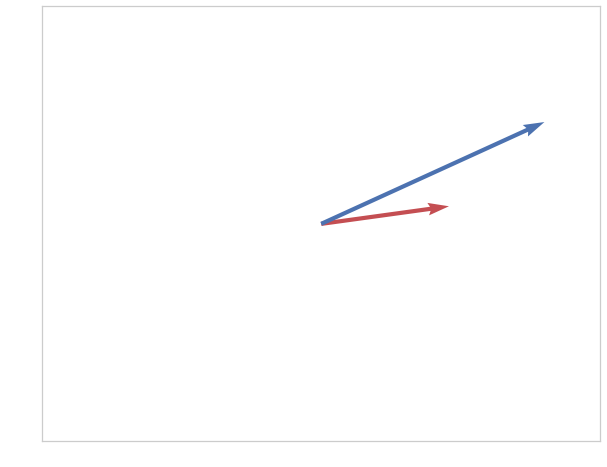

In [881]:
# # anxiety = model.wv['anxious']
import seaborn as sns

sns.set_theme(style="whitegrid")
a = model1.wv['man']
b = model1.wv['woman']

c = model1.wv['asked']
d = model1.wv['told']



# a = np.array([-1,1])
# b = np.array([1,1])
x = a + c - b

x2 = model1.wv['therapist']
x3 = model1.wv.similar_by_vector(x)

# fig = plt.figure(figsize=[15,15])
# ax = ax.gca(projection='3d')
fig, ax = plt.subplots(figsize=[10, 8])
V = np.array([a, b])
origin = np.array([[0, 0],[0, 0]]) # origin point

ax.quiver(*origin, V[:,0], V[:,1], color=['r','b','g'], scale=1.2)
# plt.xlim([-.002, .002])
# plt.show()
# model.wv.similar_by_vector(x)

ax.axes.tick_params(axis="y", colors='white', labelsize=10)
ax.axes.tick_params(axis="x", colors="white", labelsize=10)
plt.grid(False)
plt.savefig('vecs11.png', transparent=True, dpi=300)


In [795]:
a = model1.wv['man']
b = model1.wv['woman']

c = model1.wv['asked']
d = model1.wv['told']
x = a + c - b


In [834]:
df.T

,0,1,2,3
0,0.274754,0.480042,0.137768,0.130798
1,0.037833,0.218973,-0.218323,-0.032078
2,-0.164171,-0.133978,-0.070523,-0.085075
3,-0.372247,-0.458948,-0.101235,-0.109358
4,-0.037268,-0.165195,-0.164291,-0.253110
...,...,...,...,...
395,-0.103962,-0.310774,-0.070738,-0.061058
396,-0.015406,-0.199829,0.076331,0.028780
397,0.115429,0.117193,-0.199988,0.053237
398,-0.028823,-0.001502,0.057500,0.100129


In [860]:
df=pd.DataFrame([a, b, c, d]).T
df.columns =['man', 'woman', 'asked', 'unkwn']

In [861]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
man,0.274754,0.037833,-0.164171,-0.372247,-0.037268,0.101075,0.104230,0.037274,0.161033,-0.071903,...,-0.084213,0.343867,-0.382469,0.031027,0.071153,-0.103962,-0.015406,0.115429,-0.028823,-0.159223
woman,0.480042,0.218973,-0.133978,-0.458948,-0.165195,-0.092032,0.489611,-0.046069,0.275835,0.150141,...,-0.545890,0.073214,-0.364804,0.072923,0.175413,-0.310774,-0.199829,0.117193,-0.001502,-0.222169
asked,0.137768,-0.218323,-0.070523,-0.101235,-0.164291,-0.262378,0.331681,-0.050946,-0.376018,-0.049526,...,0.055749,0.252404,-0.167716,-0.023008,0.137330,-0.070738,0.076331,-0.199988,0.057500,-0.154257
unkwn,0.130798,-0.032078,-0.085075,-0.109358,-0.253110,-0.047757,0.135655,0.098978,-0.198920,-0.123798,...,-0.219559,0.027264,-0.003534,0.045699,0.186806,-0.061058,0.028780,0.053237,0.100129,-0.149901


In [838]:
# bases = [0, 0, 0]
# np.insert(a, np.array([0,0]), axis=1)
# test = np.append([0,0,0], a)

In [850]:
X

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [869]:
import plotly.express as px
from sklearn.decomposition import PCA

# df = px.data.iris()
X = df.T

pca = PCA(n_components=4)
components = pca.fit_transform(df.T)

# fig = px.scatter(components, x=0, y=1, color=df['species'])
# fig.show()

In [871]:
components

array([[-1.90774216e+00, -1.60198167e+00, -7.19960585e-01,
         1.65376260e-16],
       [-2.08635742e+00,  1.64979962e+00,  4.72105445e-01,
         1.65376260e-16],
       [ 2.32930834e+00,  7.00524652e-01, -1.20560560e+00,
         1.65376260e-16],
       [ 1.66479124e+00, -7.48342605e-01,  1.45346074e+00,
         1.65376260e-16]])

In [867]:
components.shape

(4, 4)

In [866]:
soa.shape

(4, 6)

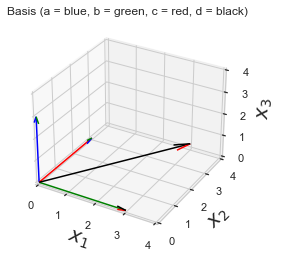

In [821]:
# a = np.array([0,0,3])
# b = np.array([3,0,0])
# c = np.array([0,3,0])
# d = np.array([2,2,2])

fig = plt.figure()
ax = fig.gca(projection="3d")
soa = np.array([[0,0,0,0,0,3], [0,0,0,3,0,0], [0,0,0,0,3,0], [0,0,0,4,2,2]])
X, Y, Z, U, V, W = zip(*soa)
ax.set_xlim3d(0, 4)
ax.set_ylim3d(0, 4)
ax.set_zlim3d(0, 4)
ax.quiver(X, Y, Z, U, V, W, length=1, arrow_length_ratio = 0.1, colors = ["blue", "green", "red", "black"])
plt.title('Basis (a = blue, b = green, c = red, d = black)')
ax.set_xlabel('$x_1$', fontsize=20)
ax.set_ylabel('$x_2$', fontsize=20)
ax.set_zlabel('$x_3$', fontsize=20)
plt.show()

In [ ]:
# x, y  = [1, 2, 3], [0.5, 0.5, 0.5]
# u1,v1 = np.random.randn(3), np.random.randn(3)
# u2,v2 = np.random.randn(3), np.random.randn(3)
# u3,v3 = np.random.randn(3), np.random.randn(3)

# QV1 = plt.quiver(x, y, u1, v1, color='r')
# QV2 = plt.quiver(x, y, u2, v2, color='b')
# QV3 = plt.quiver(x, y, u3, v3, color='g')

In [16]:
data.columns.to_list()

['created_utc',
 'subreddit',
 'author',
 'domain',
 'url',
 'num_comments',
 'score',
 'ups',
 'downs',
 'title',
 'selftext',
 'saved',
 'id',
 'from_kind',
 'gilded',
 'from',
 'stickied',
 'retrieved_on',
 'over_18',
 'thumbnail',
 'subreddit_id',
 'hide_score',
 'link_flair_css_class',
 'author_flair_css_class',
 'archived',
 'is_self',
 'from_id',
 'permalink',
 'name',
 'author_flair_text',
 'quarantine',
 'link_flair_text',
 'distinguished',
 'date',
 'text_title',
 'depression/anxiety/meds',
 'tired/sick',
 'friends/lonely',
 'school',
 'depressed/suicidal/reason',
 'sleep',
 'job',
 'friend/best/girl',
 'sad',
 'kill/suicide',
 'max_topic']

In [24]:
'030624' in repeated_posters 

True

In [41]:
# data = depression.copy()
# authors = data.groupby('author').size()
# repeated_posters = authors[(authors.index != '[deleted]')].index.to_list()
# data['repeated_poster'] = data.author.apply(lambda x: True if x in repeated_posters else False)


In [131]:
data

,created_utc,subreddit,author,domain,url,num_comments,score,ups,downs,title,...,tired/sick,friends/lonely,school,depressed/suicidal/reason,sleep,job,friend/best/girl,sad,kill/suicide,max_topic
0,1451434602,depression,IICHASE55II,self.depression,https://www.reddit.com/r/depression/comments/3...,0,1,1.0,0.0,Just got dismissed from my university,...,0.000000,0.000000,0.004461,0.000000,0.001357,0.006613,0.000000,0.000000,0.000000,job
1,1451177182,depression,rastasquirtle,self.depression,https://www.reddit.com/r/depression/comments/3...,4,14,14.0,0.0,im a spoiled piece of shit,...,0.005664,0.000867,0.000000,0.000000,0.000000,0.000000,0.003773,0.000000,0.000230,tired/sick
2,1451348063,depression,t1h3ro4w5aw6ay7,self.depression,https://www.reddit.com/r/depression/comments/3...,0,1,1.0,0.0,Caring about a person that doesn't,...,0.000000,0.002910,0.004704,0.000000,0.000000,0.000000,0.009897,0.000000,0.000000,friend/best/girl
3,1451091347,depression,iu4pkz0,self.depression,https://www.reddit.com/r/depression/comments/3...,0,0,0.0,0.0,I really screwed up this year,...,0.000000,0.000157,0.000000,0.000000,0.000000,0.000000,0.000000,0.006024,0.000000,sad
4,1451536175,depression,SmellyDagger,self.depression,https://www.reddit.com/r/depression/comments/3...,1,2,2.0,0.0,It has been 596 days since I have debated suic...,...,0.000000,0.000805,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000788,depression/anxiety/meds
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361271,1495147948,depression,mangomangelo,self.depression,https://www.reddit.com/r/depression/comments/6...,3,7,NaN,NaN,Does a therapist really help?,...,0.000000,0.000000,0.000000,0.003916,0.000000,0.000000,0.000000,0.000000,0.000000,depression/anxiety/meds
361272,1494172701,depression,franksinatraisbest,self.depression,https://www.reddit.com/r/depression/comments/6...,1,4,NaN,NaN,"I have no ambition, no desires, no interests, ...",...,0.001395,0.004246,0.004349,0.000000,0.004071,0.005378,0.000820,0.001035,0.000000,job
361273,1494005055,depression,Vanillexhope,self.depression,https://www.reddit.com/r/depression/comments/6...,1,3,NaN,NaN,I Am a Failure,...,0.000000,0.000000,0.011800,0.001595,0.002072,0.012941,0.000000,0.000000,0.000000,job
361274,1495750855,depression,Trip_SS,self.depression,https://www.reddit.com/r/depression/comments/6...,6,9,NaN,NaN,"I feel alone, sick, empty, unneeded.",...,0.010587,0.000000,0.000000,0.000000,0.009567,0.000000,0.000000,0.000000,0.000000,tired/sick


In [66]:
idk = authors[(authors.values == 3) & (authors.index != '[deleted]')]
idk.shape[0] * 3

28998

In [70]:
repeated_posters_df = data[data.repeated_poster == True].copy().reset_index()
repeated_posters_df

,index,created_utc,subreddit,author,domain,url,num_comments,score,ups,downs,...,friends/lonely,school,depressed/suicidal/reason,sleep,job,friend/best/girl,sad,kill/suicide,max_topic,repeated_poster
0,20,1450062238,depression,throwaway168233,self.depression,https://www.reddit.com/r/depression/comments/3...,6,2,2.0,0.0,...,0.000186,0.000451,0.000000,0.001659,0.000000,0.000000,0.000000,0.000000,depression/anxiety/meds,True
1,23,1449014444,depression,engxcommish,self.depression,https://www.reddit.com/r/depression/comments/3...,2,1,1.0,0.0,...,0.000000,0.001916,0.000000,0.000000,0.011483,0.000000,0.000000,0.000403,job,True
2,32,1449723822,depression,Saraphaim,self.depression,https://www.reddit.com/r/depression/comments/3...,7,8,8.0,0.0,...,0.000748,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,depression/anxiety/meds,True
3,55,1449206083,depression,johannamaeja,self.depression,https://www.reddit.com/r/depression/comments/3...,6,5,5.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000642,0.000000,0.000000,0.000000,job,True
4,61,1449826163,depression,stingraymenace,self.depression,https://www.reddit.com/r/depression/comments/3...,1,2,2.0,0.0,...,0.006119,0.000000,0.000000,0.000000,0.000000,0.000097,0.000000,0.000000,tired/sick,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60023,361258,1496034840,depression,fierydreams,self.depression,https://www.reddit.com/r/depression/comments/6...,1,1,NaN,NaN,...,0.000000,0.000000,0.000000,0.000879,0.000000,0.000000,0.000298,0.000000,sleep,True
60024,361259,1493922393,depression,Unfukkkmee,self.depression,https://www.reddit.com/r/depression/comments/6...,3,3,NaN,NaN,...,0.000000,0.007254,0.005254,0.000000,0.000000,0.000000,0.000000,0.000000,school,True
60025,361260,1493918253,depression,chadthecat,self.depression,https://www.reddit.com/r/depression/comments/6...,1,2,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,depression/anxiety/meds,True
60026,361268,1494650262,depression,unpollutedfantasy,self.depression,https://www.reddit.com/r/depression/comments/6...,2,7,NaN,NaN,...,0.000000,0.000000,0.000000,0.000683,0.000000,0.000000,0.000000,0.000000,sleep,True


In [134]:
data_copy = data[data.author != '[deleted]'].copy().reset_index()
data_copy

,index,created_utc,subreddit,author,domain,url,num_comments,score,ups,downs,...,tired/sick,friends/lonely,school,depressed/suicidal/reason,sleep,job,friend/best/girl,sad,kill/suicide,max_topic
0,0,1451434602,depression,IICHASE55II,self.depression,https://www.reddit.com/r/depression/comments/3...,0,1,1.0,0.0,...,0.000000,0.000000,0.004461,0.000000,0.001357,0.006613,0.000000,0.000000,0.000000,job
1,1,1451177182,depression,rastasquirtle,self.depression,https://www.reddit.com/r/depression/comments/3...,4,14,14.0,0.0,...,0.005664,0.000867,0.000000,0.000000,0.000000,0.000000,0.003773,0.000000,0.000230,tired/sick
2,2,1451348063,depression,t1h3ro4w5aw6ay7,self.depression,https://www.reddit.com/r/depression/comments/3...,0,1,1.0,0.0,...,0.000000,0.002910,0.004704,0.000000,0.000000,0.000000,0.009897,0.000000,0.000000,friend/best/girl
3,3,1451091347,depression,iu4pkz0,self.depression,https://www.reddit.com/r/depression/comments/3...,0,0,0.0,0.0,...,0.000000,0.000157,0.000000,0.000000,0.000000,0.000000,0.000000,0.006024,0.000000,sad
4,4,1451536175,depression,SmellyDagger,self.depression,https://www.reddit.com/r/depression/comments/3...,1,2,2.0,0.0,...,0.000000,0.000805,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000788,depression/anxiety/meds
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353382,361271,1495147948,depression,mangomangelo,self.depression,https://www.reddit.com/r/depression/comments/6...,3,7,NaN,NaN,...,0.000000,0.000000,0.000000,0.003916,0.000000,0.000000,0.000000,0.000000,0.000000,depression/anxiety/meds
353383,361272,1494172701,depression,franksinatraisbest,self.depression,https://www.reddit.com/r/depression/comments/6...,1,4,NaN,NaN,...,0.001395,0.004246,0.004349,0.000000,0.004071,0.005378,0.000820,0.001035,0.000000,job
353384,361273,1494005055,depression,Vanillexhope,self.depression,https://www.reddit.com/r/depression/comments/6...,1,3,NaN,NaN,...,0.000000,0.000000,0.011800,0.001595,0.002072,0.012941,0.000000,0.000000,0.000000,job
353385,361274,1495750855,depression,Trip_SS,self.depression,https://www.reddit.com/r/depression/comments/6...,6,9,NaN,NaN,...,0.010587,0.000000,0.000000,0.000000,0.009567,0.000000,0.000000,0.000000,0.000000,tired/sick


In [135]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

text = data_copy.text_title
tokenized_self_text = [gensim.utils.simple_preprocess(d) for d in text]

author = data_copy.author
tokenized_title = [gensim.utils.simple_preprocess(d) for d in author]


# tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(data)]
# tagged_data[1:10]

In [136]:
repeat_posters_clean = pd.DataFrame({'text': text, 'author': author})
repeat_posters_clean

,text,author
0,just got dismissed from my university i had a ...,IICHASE55II
1,im a spoiled piece of shit im on a vacation wi...,rastasquirtle
2,caring about a person that doesn't i'm a 17 ye...,t1h3ro4w5aw6ay7
3,i really screwed up this year i feel like such...,iu4pkz0
4,it has been 596 days since i have debated suic...,SmellyDagger
...,...,...
353382,does a therapist really help? for the longest ...,mangomangelo
353383,"i have no ambition, no desires, no interests, ...",franksinatraisbest
353384,i am a failure i feel like a total failure. i ...,Vanillexhope
353385,"i feel alone, sick, empty, unneeded. i've neve...",Trip_SS


In [137]:
docs = []
for idx, row in repeat_posters_clean.iterrows():
    tagged = TaggedDocument(words=row['text'], tags=[row['author']])
    docs.append(tagged)

In [138]:
docs[0]

TaggedDocument(words="just got dismissed from my university i had a reallllllly bad semester, my ocd and anxiety were at their worst, and i ended up failing a couple classes while i was already on academic probation, so i got dismissed. now i feel worthless and down, and can barely get out of bed. i have no motivation to get a job because i feel like i can't even move. obviously i can move to another city and attend another college but my gpa is pretty bad now. sorry for the rant, i just really wanted to know if their could possibly be any good outcomes out of this. thanks guys.", tags=['IICHASE55II'])

In [77]:
# docs = []
# for index, doc in enumerate(tokenized_self_text):
#     tagged = TaggedDocument(words=doc, tags=[index])
#     docs.append(tagged)

In [139]:
# define parameters for doc2vec
doc_model = gensim.models.Doc2Vec(
                                  vector_size=300,
                                  window=5,
                                  min_count=5,
                                  workers=cores,
                                  epochs=10,
                                  alpha=.025,
                                  min_alpha = 0.0001)
doc_model.build_vocab(docs)

In [140]:
# train model
doc_model.train(docs, total_examples=doc_model.corpus_count, epochs=doc_model.epochs)

In [155]:
a = '''
Slowly isolating myself
Sorry just wanted to say something to anyone really
but i used to talk to a couple people about my issues
and how i was doing but i feel like everytime i do i
annoy them and that im being boring or just a pain to be around.
I always overthink situations and im probably doing the same here but
im sat here just wishing i could talk to those i trust but i
also dont want to be a burden all the time. I cant talk to many people
and i struggle to talk to new people. Also there some of my best friends
i dont want to lose them but i also know i need to express how I feel.
Thank you for reading my rambling if you did..
'''

In [156]:
testing = gensim.utils.simple_preprocess(a)

In [161]:
repeat_posters_clean[repeat_posters_clean.author == 'throwitthe-hell-away'].values[0]

array(["in one fell sweep, i managed to fuck everything up in the span of one year. i was thinking of doing a long blog about my experiences, yadda yadda, but i figured i might as well do it in short. basically, in the space of one year, i've lost almost everything. i lost my friends because i tried to lean on them too hard and ended up being 'self-absorbed and negative' (real quote btw) and i feel like i'm in the steady process of losing my parents as the intricate lies i've set up over the past 4-5-ish years of my not being gay are being slowly unravelled. lost the crush for, well, literally blogging too hard about her and forgetting that she actually could see it. losing the social group at my current school because i'm a) too absorbed in the past and b) the friends i've made (the total of two who tbh i don't really connect with that well) have total drama with the rest of the school and its hard for me to step out. lost everything i've worked for in my old school by moving schools 

In [158]:
inferred_vector = doc_model.infer_vector(testing)
sims = doc_model.docvecs.most_similar([inferred_vector], topn=len(doc_model.docvecs))
sims[:10]

[('Injuredanddepressed', 0.18138465285301208),
 ('throwitthe-hell-away', 0.1684267818927765),
 ('Pupsbear', 0.1674778163433075),
 ('VintageTorrie', 0.16679109632968903),
 ('symph0ny95', 0.1650032252073288),
 ('JustASearcher', 0.16299882531166077),
 ('jock_jam_door_slam', 0.16211357712745667),
 ('tupacat', 0.16062667965888977),
 ('trvestory', 0.16008146107196808),
 ('gigabyte898', 0.15889379382133484)]

In [526]:
testing = '''
i really need advice on my medication i just starting taking zoloft'''

testing = gensim.utils.simple_preprocess(testing)
testing

['really',
 'need',
 'advice',
 'on',
 'my',
 'medication',
 'just',
 'starting',
 'taking',
 'zoloft']

In [934]:
vec_df = pd.DataFrame(doc_model.docvecs.vectors_docs)

In [931]:
doc_model.docvecs.vectors_docs.shape

(361275, 300)

In [940]:
import numpy as npm

In [944]:
# from nltk.cluster import KMeansClusterer, euclidean_distance

# X = doc_model.docvecs.vectors_docs
# vec = [npm.array(idk) for idk in vec_df.values]

# NUM_CLUSTERS=3
# kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=5)
# assigned_clusters = kclusterer.cluster(vectors, assign_clusters=True)

In [ ]:
assigned_clusters

In [45]:
# model = gensim.models.Word2Vec.load("models/depression2vec.model")
model = gensim.models.Word2Vec.load("models/depression2vec.model")

words = []
counts =[]
w2v = model
for index in range(len(w2v.wv.index2word)):
    word = w2v.wv.index2word[index]
    words.append(word)
    counts.append(w2v.wv.vocab[word].count)
    
pd.DataFrame({'word':words, 'count':counts}).to_csv('/Users/collinswestnedge/programming/project_05/tensor_data/depression/depression2_meta.tsv', index=False,sep='\t' )

import io

# Vector file, `\t` seperated the vectors and `\n` seperate the words
# """
# 0.1\t0.2\t0.5\t0.9
# 0.2\t0.1\t5.0\t0.2
# 0.4\t0.1\t7.0\t0.8
# """

path2 = '/Users/collinswestnedge/programming/project_05/tensor_data/depression/depression2_'

out_v = io.open(path2+'vecs.tsv', 'w', encoding='utf-8')

# Meta data file, `\n` seperated word
# """
# token1
# token2
# token3
# """
# out_m = io.open(path2+'meta.tsv', 'w', encoding='utf-8')

# Write meta file and vector file
for index in range(len(w2v.wv.index2word)):
    word = w2v.wv.index2word[index]
    vec = w2v.wv.vectors[index]
    count = w2v.wv.vocab[word].count
#     out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
# out_m.close()

In [13]:
# doc_vec_df = pd.DataFrame(doc_model.docvecs.vectors_docs)
# doc_vec_df['num_comments'] = df_full.num_comments
# doc_vec_df['docs'] = df_full.text_title
# doc_vec_df.head()

# cols= [str(i) for i in range(doc_model.docvecs.vectors_docs.shape[1])]
# cols.append('num_comments')
# cols.append('docs')

# doc_vec_df.columns = cols
# doc_vec_df

In [ ]:
doc_model = 

In [1]:
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# X = doc_model.docvecs.vectors_docs
# length = npm.sqrt((X**2).sum(axis=1))[:,None]
# Xscl = X / length

# X_Norm = scaler.fit_transform(doc_vec_df.iloc[:,0:-2])
# to normalise existing X
# X_Norm

# kmeans = KMeans(init='k-means++', n_clusters=5, n_init=10)
# kmeans.fit(Xscl)
# doc_model = Doc2Vec.load("docvec.model")

# from sklearn.cluster import DBSCAN
# X = doc_model.docvecs.vectors_docs
# clustering = DBSCAN(eps=3, min_samples=5, metric='cosine').fit(X)
# clustering.labels_

In [ ]:
temp_depression = df_full[['selftext', 'max_topic']].copy()
temp_depression['label'] = clustering.labels_

temp_depression.groupby('label').max_topic.value_counts(normalize=True)

In [985]:
kmeans.labels_.shape

(361275,)

In [986]:
doc_vec_copy = doc_vec_df.copy()
doc_vec_copy['labels'] = kmeans.labels_
doc_vec_copy['topic'] = df_full.max_topic

In [987]:
doc_vec_copy.groupby('labels').topic.value_counts(normalize=True).head(50)

labels  topic                    
0       depression/anxiety/meds      0.234128
        friends/lonely               0.120373
        school                       0.102583
        job                          0.099152
        sleep                        0.092855
        friend/best/girl             0.078879
        kill/suicide                 0.078621
        depressed/suicidal/reason    0.073970
        sad                          0.066682
        tired/sick                   0.052756
1       depression/anxiety/meds      0.232509
        friends/lonely               0.117118
        school                       0.104790
        job                          0.099607
        sleep                        0.094935
        friend/best/girl             0.077581
        depressed/suicidal/reason    0.076639
        kill/suicide                 0.075579
        sad                          0.067452
        tired/sick                   0.053789
2       depression/anxiety/meds      0.236160


In [975]:
# doc_vec_copy.max_topic.unique()

In [976]:
# doc_vec_df['max_topic'] = df_full.max_topic
# doc_vec_df[doc_vec_df.max_topic == 'kill/suicide'].labels.value_counts()

In [ ]:
inertia = []
sil = []
# changing the number of clusters 
for k in range(5,30):
    
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(X_Norm)
    y_pred = km.predict(X_Norm)
    inertia.append((k, km.inertia_))
    print(k)

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(12,4))

# Plotting Elbow Curve
x_iner = [x[0] for x in inertia]
y_iner  = [x[1] for x in inertia]
ax[0].plot(x_iner, y_iner)
ax[0].set_xlabel('Number of Clusters')
ax[0].set_ylabel('Intertia')
ax[0].set_title('Elbow Curve')

